In [1]:
import math
import numpy as np
import pandas as pd
import sys
import re
from functions import *
from mining_functions import *
from collections import Counter
from matplotlib.backends.backend_pdf import PdfPages
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
PATH = '/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
def get_path(path = PATH):
    if os.name == 'posix':
        return os.environ['HOME']+path #'/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
    elif os.name == 'nt':
        return os.environ['USERPROFILE']+ path.replace('/','\\') #'\\Google Drive\Jonathan Sarah Ido folder\data\CCK\\'
    else:
        raise Exception('OS not recongnized. I\'m confused.')
gitpath = '/Documents/git/Phet-log-analyzer/cck/raw_data_parsing_check/'
df = pd.read_csv(get_path(path = gitpath) + 'phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
# dfx = pd.read_csv('C:\Users\Sarah\Documents\git\Phet-log-analyzer\cck\\raw_data_parsing_check\phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
df["student"] = df["student"].astype('category')
df["Family"]=df["Family"].str.capitalize()
df["Family_tool"]=df["Family_tool"].str.capitalize()
df["Family_default"]=df["Family_default"].str.capitalize()
df["Family_both"]=df["Family_both"].str.capitalize()

df_scores = pd.read_csv(data_path + 'MATCHING_phet_cck_user_data_anonymized.txt')
df_scores["student"] = df_scores["student"].astype('category')

### Functions used to calculate information gain, plot use, etc...

In [11]:
def add_text(attribute,family_category,cut_off, shortest_seq_length, longest_seq_length,B):
    text = """Showing sequences for students split by {0}, using the categories {1}.
            Removed sequences used by less than {2}% of students.
            Found sequences of lenght {3} to {4}.
            Using {5} time bins""".format(attribute,family_category,int(cut_off*100), shortest_seq_length, longest_seq_length,B)
    fig = plt.figure(figsize=(10, 4))
    ax = plt.gca()
    ax.text(0.5,0.5,text,
        horizontalalignment='center',
        verticalalignment='center',
        fontsize = 15)
    plt.axis('off')
    return fig

In [4]:
def rank_sequences(sequence_counts,B,axesnum=None):
    ranks = []
    for seq,counts in sequence_counts.iteritems():
#         if np.sum(counts)>0:
        ranks.append((seq,calc_infogain(counts,B,axesnum)))
    return sorted(ranks, key=lambda tup: tup[1])

def get_top_seqs(ranks,N):
    return ranks[-N:]

### Let's investigate how best to split students

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000CE942E8>]], dtype=object)

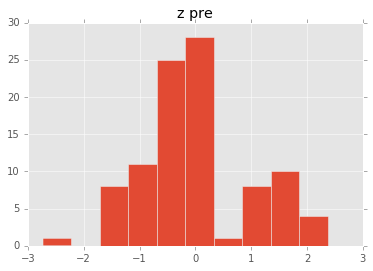

In [5]:
df_scores.hist(column='z pre')

#### Clearly, students' pre test is a bi modal distribution. Let's split them this way.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000A38A3C8>]], dtype=object)

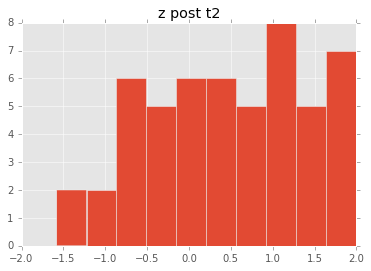

In [6]:
def label_learning (median,row,column):
    if row[column] >= median: return 'high'
    else: return 'low'
    
median_learning1 = np.median(df_scores['z post t1'])
df_scores['split_post_t1'] = df_scores.apply (lambda row: label_learning (median_learning1,row,"z post t1"),axis=1)
df_scores[df_scores['split_post_t1']=='high'].hist(column='z post t2')

In [7]:
median_learning1 = 0.45
df_scores['split pre'] = df_scores.apply (lambda row: label_learning (median_learning1,row,"z pre"),axis=1)
median_learning1 = np.median(df_scores[df_scores['split pre']=='low']['z post t2'])
df_scores['split post t2'] = df_scores.apply (lambda row: label_learning (median_learning1,row,"z post t2"),axis=1)

In [8]:
for x in ['high','low']:
    for y in ['high','low']:
        print x,y, len(set(df_scores[(df_scores['split pre']==x)&(df_scores['split post t2']==y)]['student']))

high high 19
high low 3
low high 38
low low 36


In [9]:
a = set(get_students('split post t2','high'))
b = set(get_students('used this circuit sim before?',1))
c = set(get_students('split post t2','low'))
print len(a), len(b), len(a.intersection(b)), len(c.intersection(b))

57 37 20 17


### We can calculate the information gain of each sequence by time bin 
given a split by pre test

For attribute split pre, category Family
Getting sequence use over 4 time bins for 96 students split by split pre. 
    Keeping only sequences used once by at least 20% of students 
    in each group and overall.
For attribute split pre, category Family
Getting sequence use over 1 time bins for 96 students split by split pre. 
    Keeping only sequences used once by at least 20% of students 
    in each group and overall.
For attribute split pre, category Family
Getting sequence use over 4 time bins for 96 students split by split pre. 
    Keeping only sequences used once by at least 20% of students 
    in each group and overall.
For attribute split pre, category Family_tool
Getting sequence use over 4 time bins for 96 students split by split pre. 
    Keeping only sequences used once by at least 20% of students 
    in each group and overall.
For attribute split pre, category Family_tool
Getting sequence use over 1 time bins for 96 students split by split pre. 
    Keeping only seque

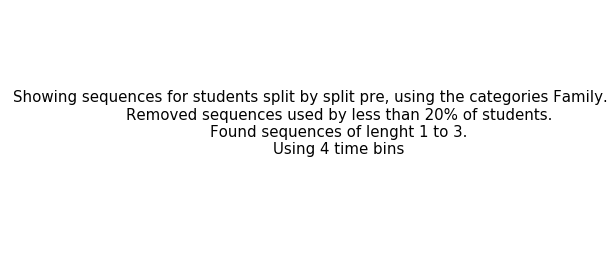

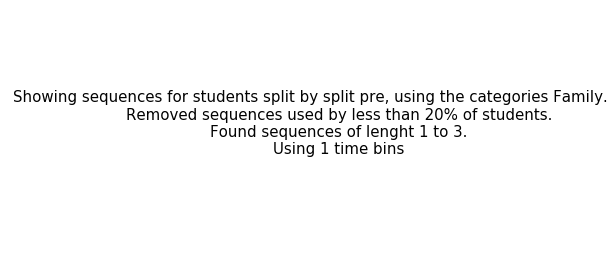

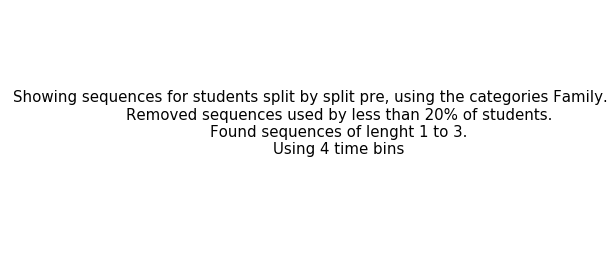

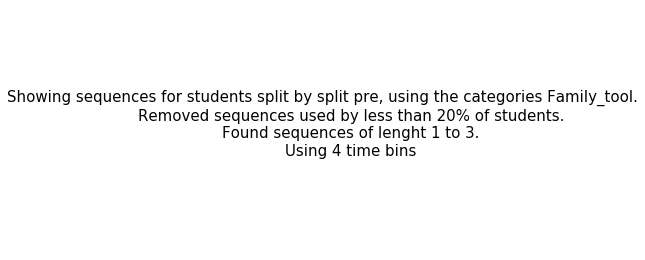

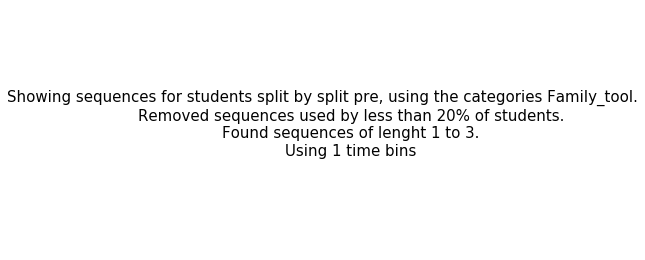

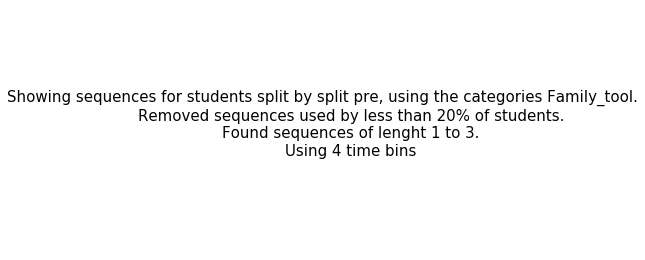

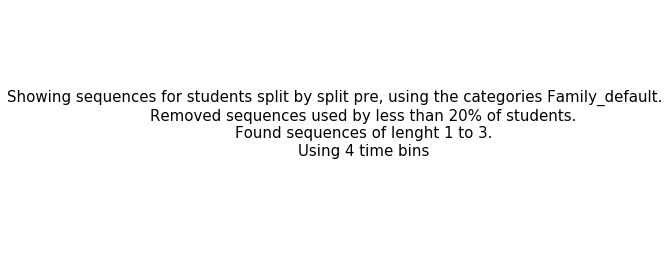

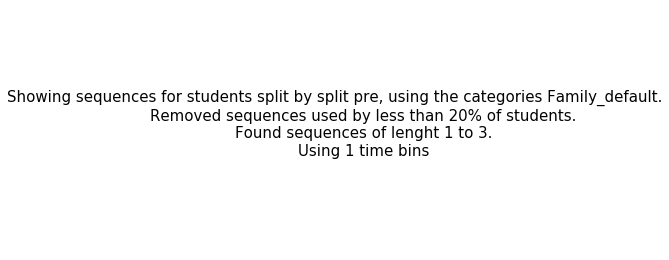

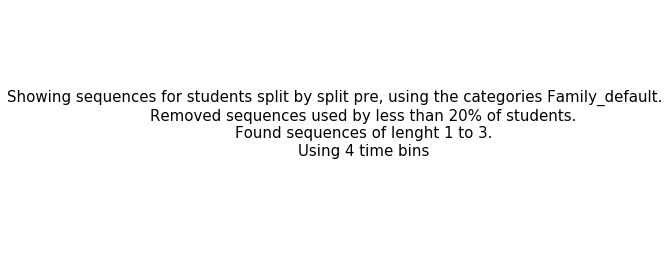

In [28]:
students = get_students()
CUT_OFF = 0.20 #we keep only sequences used once by at least 20% of students
shortest_seq_length = 1
longest_seq_length = 3
BINS = 4  #number of bins

### PARAMETERS
attributes = [('split pre','high','low')]
family_categories = ["Family","Family_tool","Family_default"]

parse_axis = {0:'time',1:'group',None:'time and group'}
pdf = PdfPages('infogain_results_by_pre.pdf')

for attribute,level1,level2 in attributes:
    for family_category in family_categories:
        for axis in [0,1,None]:
            if axis == 1: B = 1
            else: B = BINS
        
            print "For attribute {0}, category {1}".format(attribute,family_category)
            pdf.savefig(add_text(attribute,family_category,CUT_OFF, shortest_seq_length, longest_seq_length,B))
            sequence_counts = get_sequence_use_by_timebin(df,students,family_category,
                                                          B,attribute,level1,level2,
                                                          shortest_seq_length,longest_seq_length,CUT_OFF)
            ylabels = [level1,level2]
            tops = get_top_seqs(rank_sequences(sequence_counts,B,axis),5)
            for seq,infogain in tops:
#                 print seq, sequence_counts[seq]
                title = '{0}: infogain {1} by {2}'.format(seq,round(infogain,3),parse_axis[axis])
                plot = plot_heat_map(sequence_counts[seq],title, ylabels)
                pdf.savefig( plot )
                plot.clf()
pdf.close()

### We can calculate the information gain of each sequence by time bin 
given a split by post test, for only students that did poorly on pre test

For attribute split post t2, categories Family
Getting sequence use over 4 time bins for 74 students split by split post t2. 
    Keeping only sequences used once by at least 20% of students 
    in each group and overall.
For attribute split post t2, categories Family
Getting sequence use over 1 time bins for 74 students split by split post t2. 
    Keeping only sequences used once by at least 20% of students 
    in each group and overall.
For attribute split post t2, categories Family
Getting sequence use over 4 time bins for 74 students split by split post t2. 
    Keeping only sequences used once by at least 20% of students 
    in each group and overall.
For attribute split post t2, categories Family_tool
Getting sequence use over 4 time bins for 74 students split by split post t2. 
    Keeping only sequences used once by at least 20% of students 
    in each group and overall.
For attribute split post t2, categories Family_tool
Getting sequence use over 1 time bins for 74 studen

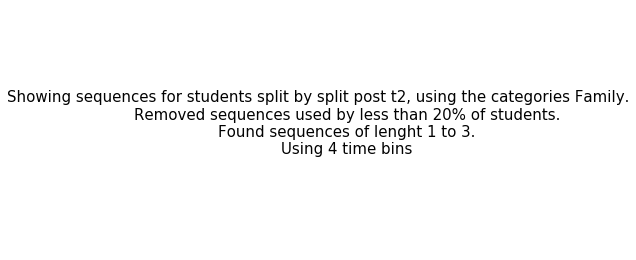

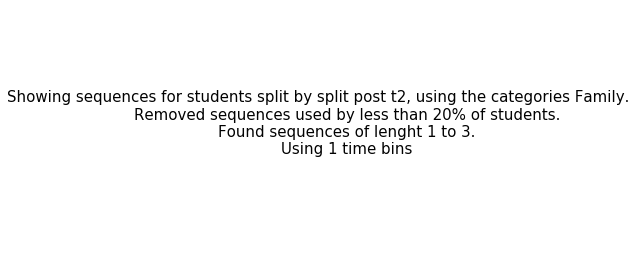

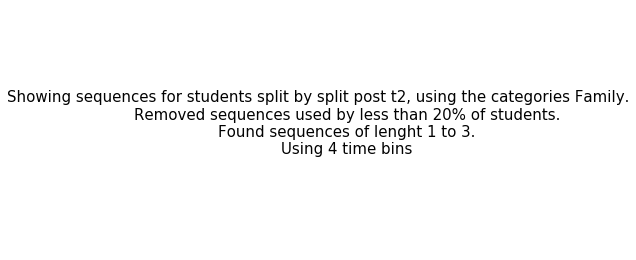

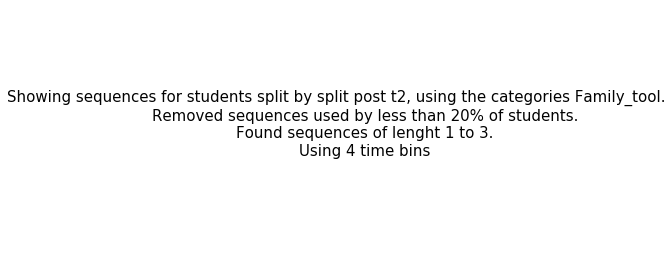

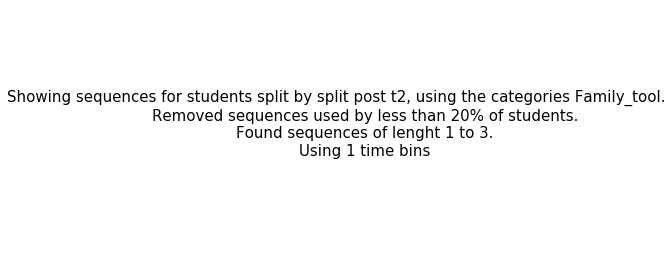

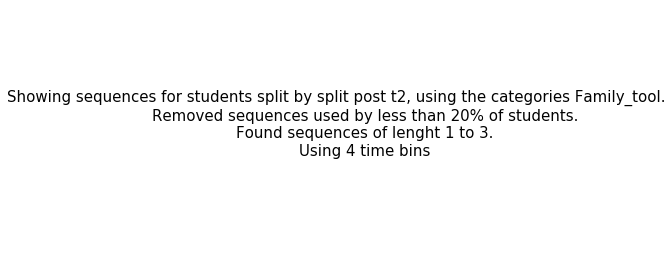

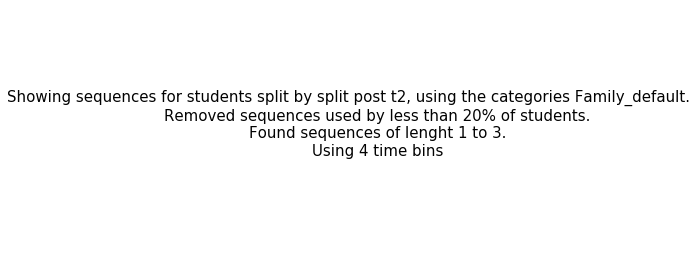

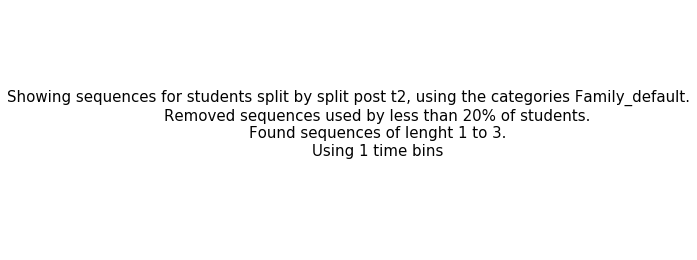

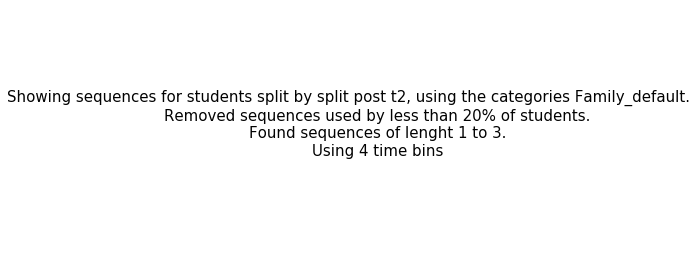

In [29]:
students = get_students(attribute='split pre',level='low')
CUT_OFF = 0.20 #we keep only sequences used once by at least 10% of students
shortest_seq_length = 1
longest_seq_length = 3
BINS = 4  #number of bins

### PARAMETERS
attributes = [('split post t2','high','low')]
family_categories = ["Family","Family_tool","Family_default"]

parse_axis = {0:'time',1:'group',None:'time and group'}
pdf = PdfPages('infogain_results_by_post2.pdf')

for attribute,level1,level2 in attributes:
    for family_category in family_categories:
        for axis in [0,1,None]:
            if axis == 1: B = 1
            else: B = BINS
        
            print "For attribute {0}, categories {1}".format(attribute,family_category)
            pdf.savefig(add_text(attribute,family_category,CUT_OFF, shortest_seq_length, longest_seq_length,B))
            sequence_counts = get_sequence_use_by_timebin(df,students,family_category,
                                                          B,attribute,level1,level2,
                                                          shortest_seq_length,longest_seq_length,CUT_OFF)
            ylabels = [level1,level2]
            tops = get_top_seqs(rank_sequences(sequence_counts,B,axis),5)
            for seq,infogain in tops:
                title = '{0}: infogain {1} by {2}'.format(seq,round(infogain,3),parse_axis[axis])
                plot = plot_heat_map(sequence_counts[seq],title, ylabels)
                pdf.savefig( plot )
                plot.clf()
pdf.close()

## Taking a closer look at interesting sequences

In [30]:
pdf = PdfPages('results_short_seqs.pdf')
sequence_counts = get_sequence_use_by_timebin(df,students,'Family',
                                                          B,'split post t2','high','low',
                                                          shortest_seq_length,longest_seq_length,CUT_OFF)
interesting_seqs = ['CPC','PTbP','PTsP','PTcP','CTbC','CTsC','CTcC']
for seq in interesting_seqs:
    plot = plot_heat_map(sequence_counts[seq],seq,ylabels)
    pdf.savefig( plot )
    plot.clf()
pdf.close()

Getting sequence use over 4 time bins for 74 students split by split post t2. 
    Keeping only sequences used once by at least 20% of students 
    in each group and overall.


### We repeat the same analysis, only remove the first time bin before to see if what students do in other time bins differentiates them as well (though not as significantly).

In [ ]:
# parse_axis = {0:'time',1:'group',None:'time and group'}

# pdf = PdfPages('infogain_results_no_first_bin.pdf')

# for attribute,level1,level2 in attributes:
#     for family_category in family_categories:
#         for axis in [0,1,None]:
#             if axis == 1:
#                 B = 1
#             else:
#                 B = 3
        
#             print "For attribute {0}, categories {1}".format(attribute,family_category)
#             pdf.savefig(add_text(attribute,family_category,N, shortest_seq_length, longest_seq_length,B))
#             sequence_counts = get_sequence_use_by_timebin(df,students,family_category,B,attribute,level1,level2,shortest_seq_length,longest_seq_length,N)
#             sequence_counts = remove_first_bin(sequence_counts)
#             ylabels = [level1,level2]
#             tops = get_top_seqs(rank_sequences(sequence_counts,B,axis),1)
#             for seq,infogain in tops:
#                 print seq, sequence_counts[seq]
#                 title = '{0}: infogain {1} by {2}'.format(seq,round(infogain,3),parse_axis[axis])
#                 plot = plot_heat_map(sequence_counts[seq],title, ylabels)
#                 pdf.savefig( plot )
#                 plot.clf()
# pdf.close()

In [ ]:
# def remove_first_bin(sequence_counts):
#     new_seq_counts = {}
#     for s,c in sequence_counts.iteritems():
#         new_seq_counts[s] = c[:,1:]
#     return new_seq_counts  